## Customer Segmentation Analysis 

#### Introduction

This notebook presents an end-to-end customer segmentation analysis using clustering techniques. The objective is to identify distinct customer groups based on demographic attributes, purchasing behavior, and campaign response, and to translate these segments into actionable business insights. 

The analysis begins with data preparation and feature engineering, including the removal of redundant variables, creation of aggregated behavioral metrics, and data cleaning. A clustering pipeline is then developed, with emphasis on selecting the optimal number of clusters and ensuring reproducibility through standardized preprocessing and modeling steps.

Finally, the resulting clusters are profiled using both numerical and categorical variables to understand the defining characteristics of each segment. These profiles are interpreted from a business perspective, enabling targeted marketing, personalization strategies, and improved customer lifecycle management.

## Contents

1. **Data Preparation and Feature Engineering** 

   1.1 Removal of Redundant Columns  
   1.2 Creation of Aggregated Variables  
   1.3 Feature Engineering (Completed during EDA)
   1.4 Data Cleaning  

2. **Modeling** 

   2.1 Setting Up the Pipeline    
   2.2 Finding the Optimal K Value       
   2.3 Building the Model

3. **Profile Analysis** 

   3.1 Cluster Profile Analysis for Categorical Variables  
   3.2 Cluster Profile Analysis for Numerical Variables  


In [1]:
#Importing Libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
os.environ["OMP_NUM_THREADS"] = "9"

from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from sklearn.manifold import TSNE
import joblib


In [2]:
#Reading the dataset
df= pd.read_csv("marketing_campaign_extended.csv")

In [3]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Family_Size', 'Customer_Tenure_Years', 'Recency_Category',
       'TotalPurchases'],
      dtype='object')

## 1. Data Preperation and Feature Engineering

### 1.1 Removal of Redundant Columns
The following columns were removed as they were either identifiers, replaced by derived features, or contained no analytical value:

- `ID`
- `Year_Birth` (replaced by **Age**)
- `Dt_Customer` (replaced by **Customer_Tenure_Years**)
- `Z_CostContact` (dummy column)
- `Z_Revenue` (dummy column)

---

### 1.2 Creation of Aggregated Variables
New variables were created by aggregating existing columns to better capture overall customer behavior:

#### 1.2.1 TotalPurchases  
Sum of monetary spend across product categories:
- `MntWines`
- `MntFruits`
- `MntMeatProducts`
- `MntFishProducts`
- `MntSweetProducts`
- `MntGoldProds`  
*(Already created in the EDA notebook)*

#### 1.2.2 TotalPurchaseCount  
Total number of purchases across all channels:
- `NumWebPurchases`
- `NumCatalogPurchases`
- `NumStorePurchases`

#### 1.2.3 TotalAcceptedCmp  
Total number of accepted marketing campaigns, calculated as the sum of:
- `AcceptedCmp1`
- `AcceptedCmp2`
- `AcceptedCmp3`
- `AcceptedCmp4`
- `AcceptedCmp5`
- `Response` (Final Campaign)

---

### 1.3 Features Created During EDA
The following additional features were engineered as part of the exploratory data analysis process:

- `Age` : Derived from the year of birth
- `Family_Size`: Calculated based on marital status and number of children
- `Customer_Tenure_Years`: Derived from the customer enrollment date (Dt_Customer)
- `Recency_Category`: Customer segmentation based on the number of days since the last purchase (Recency)

-----
**Note:** Please see the **README file** for detailed variable descriptions.

In [4]:
# 1. Removing Redunant Columns

df.drop(columns=["ID", "Year_Birth","Dt_Customer","Z_CostContact", "Z_Revenue"], inplace=True)

# 2. Creating new Variables aggregating columns

#2.1 Total Purchases: Already Done in the previous EDA notebook (Removing these columns)
df.drop(columns=["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"], inplace=True)

#2.2 TotalPurchaseCount
df['TotalPurchaseCount'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] 

df.drop(columns=["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"], inplace=True)

#2.3 TotalAcceptedCmp : Total number of campaigns accepted
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5'] +df["Response"]

df.drop(columns=["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5","Response"], inplace=True)  

In [5]:
df.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'NumDealsPurchases', 'NumWebVisitsMonth', 'Complain', 'Age',
       'Family_Size', 'Customer_Tenure_Years', 'Recency_Category',
       'TotalPurchases', 'TotalPurchaseCount', 'TotalAcceptedCmp'],
      dtype='object')

### 1.4 Data Cleaning 
1.4.1 Treatment of Missing Values 

1.4.2 Removal of Outliers 

#### 1.4.1 Treatment of Missing Values 

In [6]:
df.isnull().sum()

Education                 0
Marital_Status            0
Income                   24
Kidhome                   0
Teenhome                  0
Recency                   0
NumDealsPurchases         0
NumWebVisitsMonth         0
Complain                  0
Age                       0
Family_Size               0
Customer_Tenure_Years     0
Recency_Category          0
TotalPurchases            0
TotalPurchaseCount        0
TotalAcceptedCmp          0
dtype: int64

In [7]:
df['Income'].isnull().mean() * 100

1.0714285714285714

Only the Income variable contains missing values. Since these account for approximately 1% of the dataset, the corresponding records were removed.

In [8]:
#Removing Missing Values in Income Column
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
df.dropna(subset=['Income'], inplace=True)

#### 4.2 Removal of Outliers

Based on exploratory data analysis, outliers were identified in the **Income** and **Age** variables. These outliers may disproportionately influence statistical summaries and distance-based models such as clustering.

All other variables were assessed and found to be within reasonable ranges, requiring no additional outlier treatment at this stage. 

<function matplotlib.pyplot.show(close=None, block=None)>

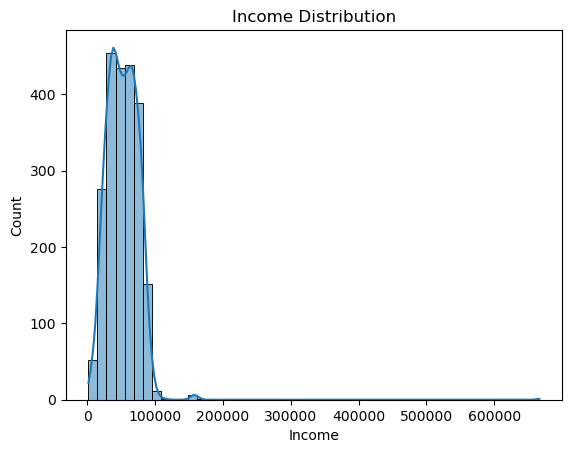

In [9]:
#Distribution of Income
sns.histplot(data=df,x='Income',bins=50,kde=True)
plt.title('Income Distribution')
plt.show

Removing any income over 120,000

In [10]:
# Removing Outliers in Income Column
df = df[df['Income'] <= 120000]

<function matplotlib.pyplot.show(close=None, block=None)>

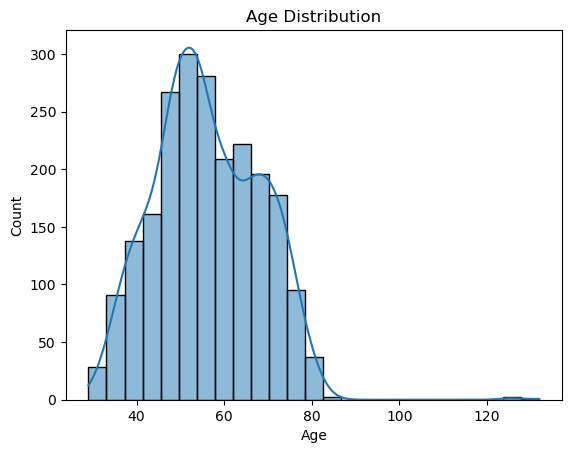

In [11]:
# Distribution of Age
sns.histplot(data=df,x='Age',bins=25,kde=True)
plt.title('Age Distribution')
plt.show    

Removing any customers with age over 90 years

In [12]:
df = df[df["Age"] <= 90]

Checking accuracy of data types before creating the model

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2239
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Education              2205 non-null   object 
 1   Marital_Status         2205 non-null   object 
 2   Income                 2205 non-null   float64
 3   Kidhome                2205 non-null   int64  
 4   Teenhome               2205 non-null   int64  
 5   Recency                2205 non-null   int64  
 6   NumDealsPurchases      2205 non-null   int64  
 7   NumWebVisitsMonth      2205 non-null   int64  
 8   Complain               2205 non-null   int64  
 9   Age                    2205 non-null   int64  
 10  Family_Size            2205 non-null   int64  
 11  Customer_Tenure_Years  2205 non-null   float64
 12  Recency_Category       2205 non-null   object 
 13  TotalPurchases         2205 non-null   int64  
 14  TotalPurchaseCount     2205 non-null   int64  
 15  TotalAcce

Converting Complain from int64 data type to Category

In [14]:
df['Complain'] = df['Complain'].astype('category')

## 2.Modeling 
   
   ### 2.1 Setting Up the Pipeline
   
Pipeline Creation Steps

1. Label Encoding for Categorical Features 
2. Scaling for Numerical Features
3. Building the K-means Clustering Model

In [15]:
# Separating column types
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_transformed = preprocessor.fit_transform(df)

### 2.2 Finding the Optimal K Value  
 

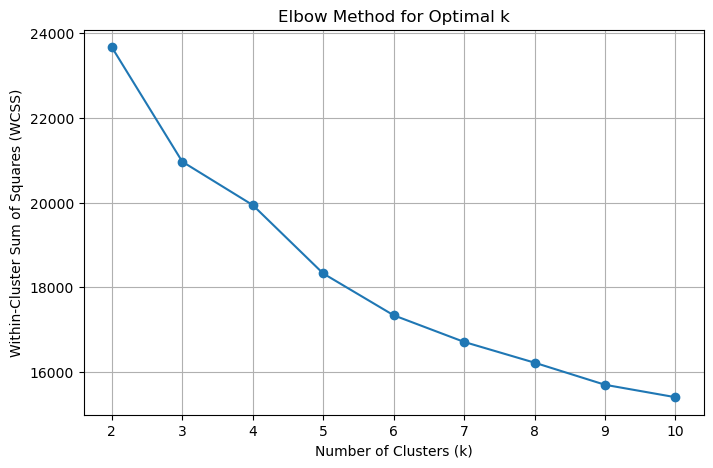

In [16]:
# Elbow Method to find optimal number of clusters

wcss = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_transformed)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()   


Computing the silhouette score

In [17]:
wcss = []
sil_scores = []
K = range(2, 11)  # check clusters from 2 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_transformed)
    
    # WCSS
    wcss.append(kmeans.inertia_)
    
    # Silhouette Score
    score = silhouette_score(X_transformed, labels)
    sil_scores.append(score)


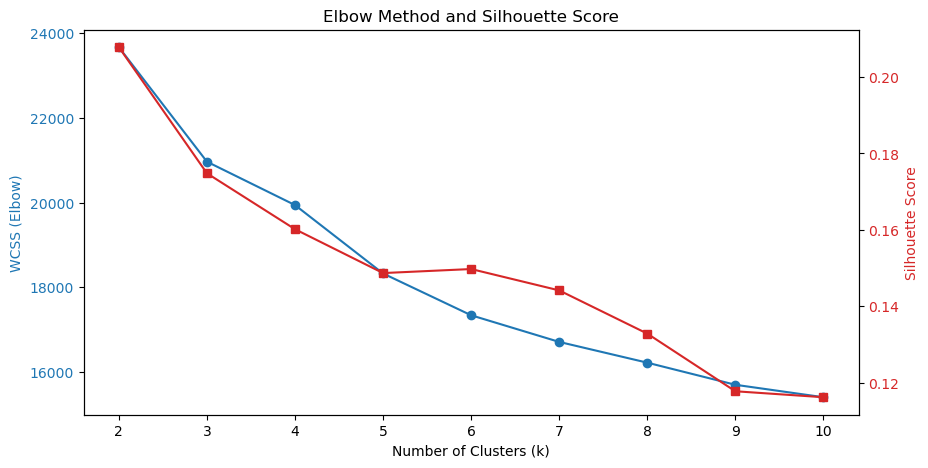

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:blue'
ax1.plot(K, wcss, marker='o', color=color)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('WCSS (Elbow)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
color = 'tab:red'
ax2.plot(K, sil_scores, marker='s', color=color)
ax2.set_ylabel('Silhouette Score', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method and Silhouette Score')
plt.show()


A high silhouette score indicates that the clusters are well separated, we want the inter-cluster distances to be small while the intra-cluster distances being large. 

Picking 4 as the optiomal number of clusters. Low WCSS and the silhuette score drops after that. 

### 2.3 Building the Model

In [19]:
#Fitting the model for optimal k of 4
optimal_k = 4  

clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(n_clusters=optimal_k, init='k-means++', random_state=42))
])

clustering_pipeline.fit(df)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'NumDealsPurchases',
       'NumWebVisitsMonth', 'Age', 'Family_Size', 'Customer_Tenure_Years',
       'TotalPurchases', 'TotalPurchaseCount', 'TotalAcceptedCmp'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['Education', 'Marital_Status', 'Complain', 'Recency_Category'], dtype='object'))])),
                ('cluster', KMeans(n_clusters=4, random_state=42))])

In [20]:
# Assiging cluster labels to DataFrame
df['Cluster'] = clustering_pipeline.named_steps['cluster'].labels_

In [21]:
#Saving the model
joblib.dump(clustering_pipeline, 'clustering_pipeline.pkl')

['clustering_pipeline.pkl']

### 3. Profile Analysis

In [22]:
sil_score = silhouette_score(X_transformed, df['Cluster'])
sil_score

0.16016635110759053

In [35]:
# Analysis size of each cluster
df.Cluster.value_counts()

Cluster
1    907
2    705
3    434
0    159
Name: count, dtype: int64

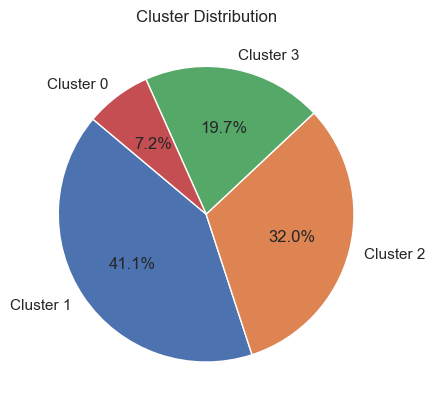

In [33]:
plt.pie(df.Cluster.value_counts(), labels=['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 0'], autopct='%1.1f%%', startangle=140)
plt.title('Cluster Distribution')
plt.show()

#### 3.1 Cluster Analysis for Categorical Variables

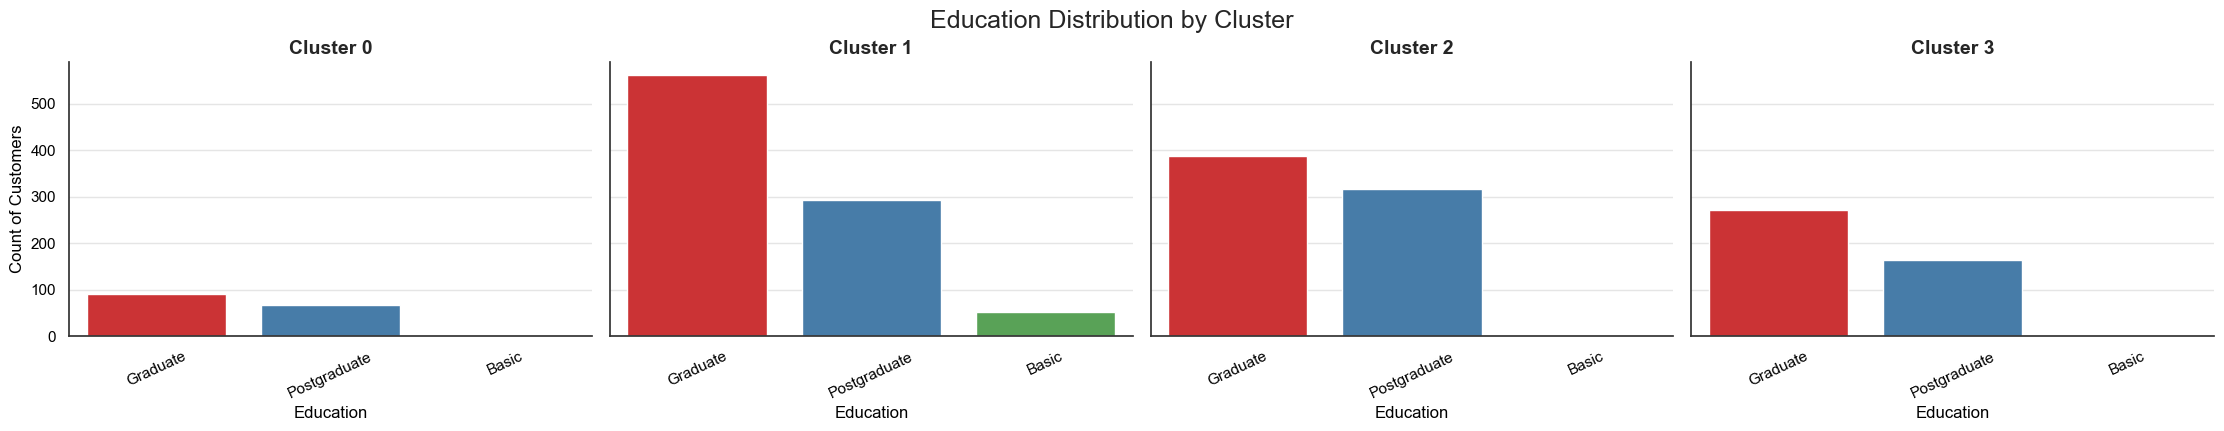

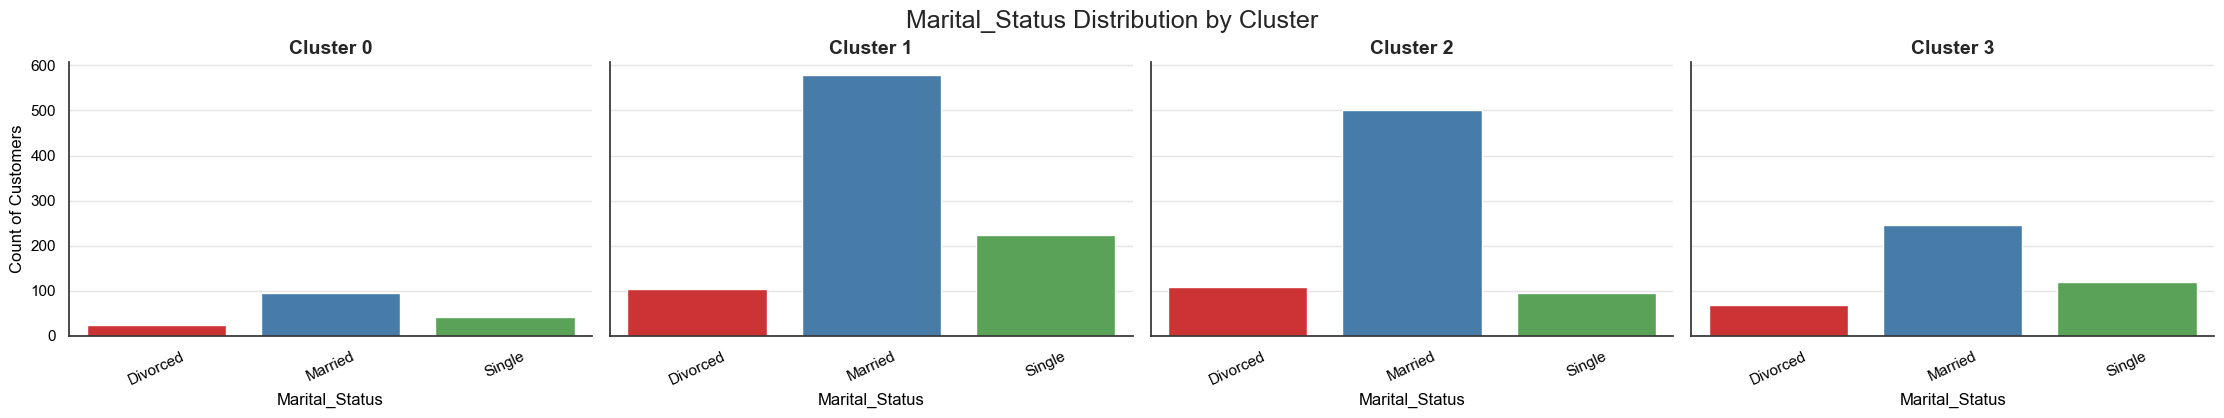

C:\Users\dilun\AppData\Local\Temp\ipykernel_10592\4132183030.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(['Cluster', col], as_index=False)


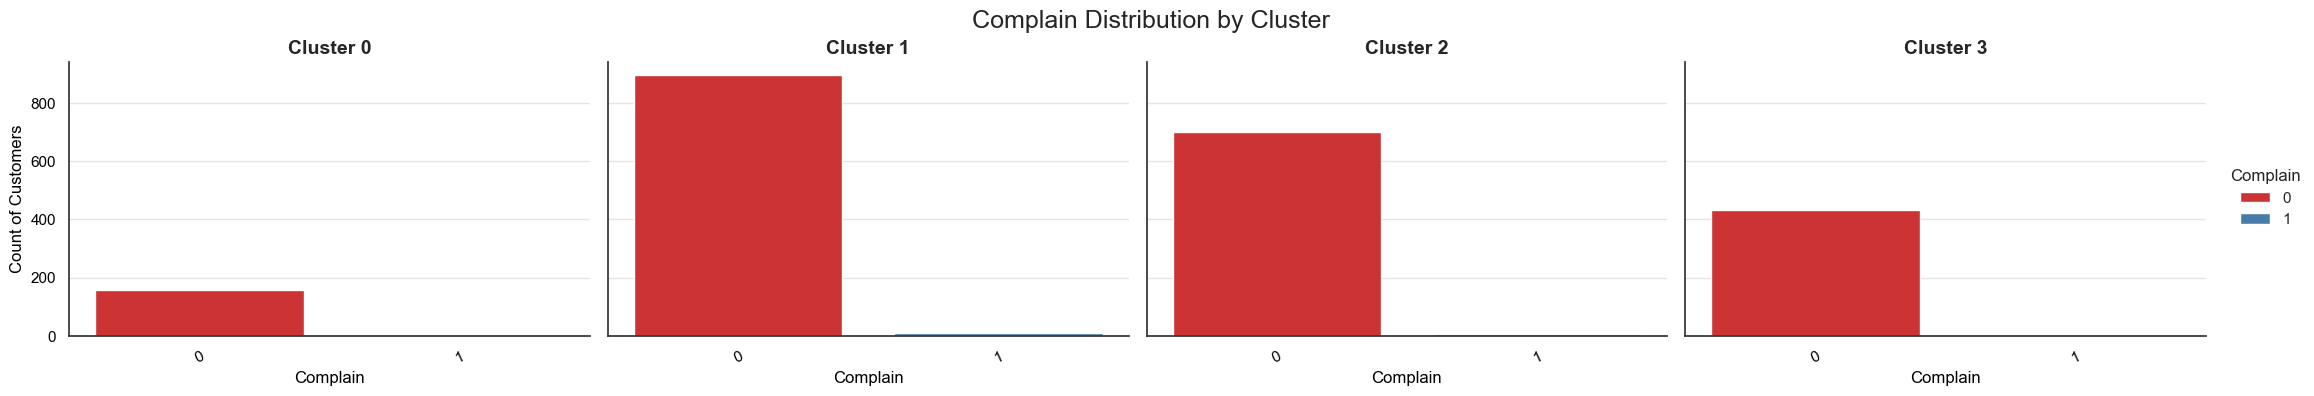

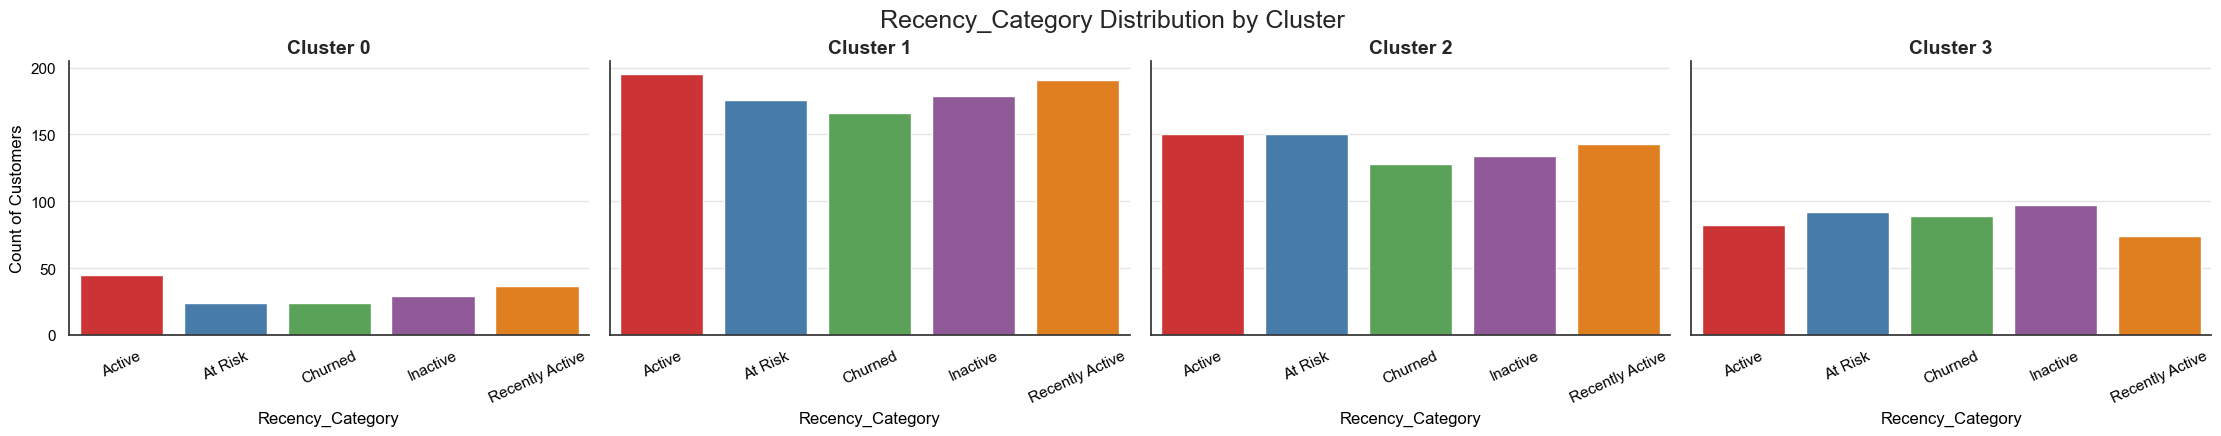

In [24]:
#------------------Cluster Analysis for Categorical Variables -------------------------#
# -------------------- THEME --------------------
sns.set_theme(
    style="whitegrid",
    rc={
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'grid.color': '#e5e5e5',
        'axes.edgecolor': '#333333',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black'
    }
)

# -------------------- CATEGORICAL COLUMNS --------------------
categorical_cols = (
    df.select_dtypes(include=['object', 'category'])
      .columns
      .drop('Cluster', errors='ignore')
)

# -------------------- FACETGRID PLOTS --------------------
for col in categorical_cols:

    plot_df = (
        df.groupby(['Cluster', col], as_index=False)
          .size()
          .assign(
              Proportion=lambda x: x['size'] /
              x.groupby('Cluster')['size'].transform('sum')
          )
    )

    g = sns.catplot(
        data=plot_df,
        x=col,
        y='size',
        col='Cluster',
        kind='bar',
        col_wrap=4,
        height=4,
        aspect=1.4,          # wider plots
        palette='Set1',
        hue=col
    )

    g.set_titles("Cluster {col_name}", size=14, fontweight='bold')
    g.set_axis_labels(col, "Count of Customers")

    for ax in g.axes.flatten():
        ax.tick_params(axis='x', rotation=25)

    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{col} Distribution by Cluster", fontsize=18)

    plt.show()


#### 4.2 Cluster Analysis for Numerical Variable

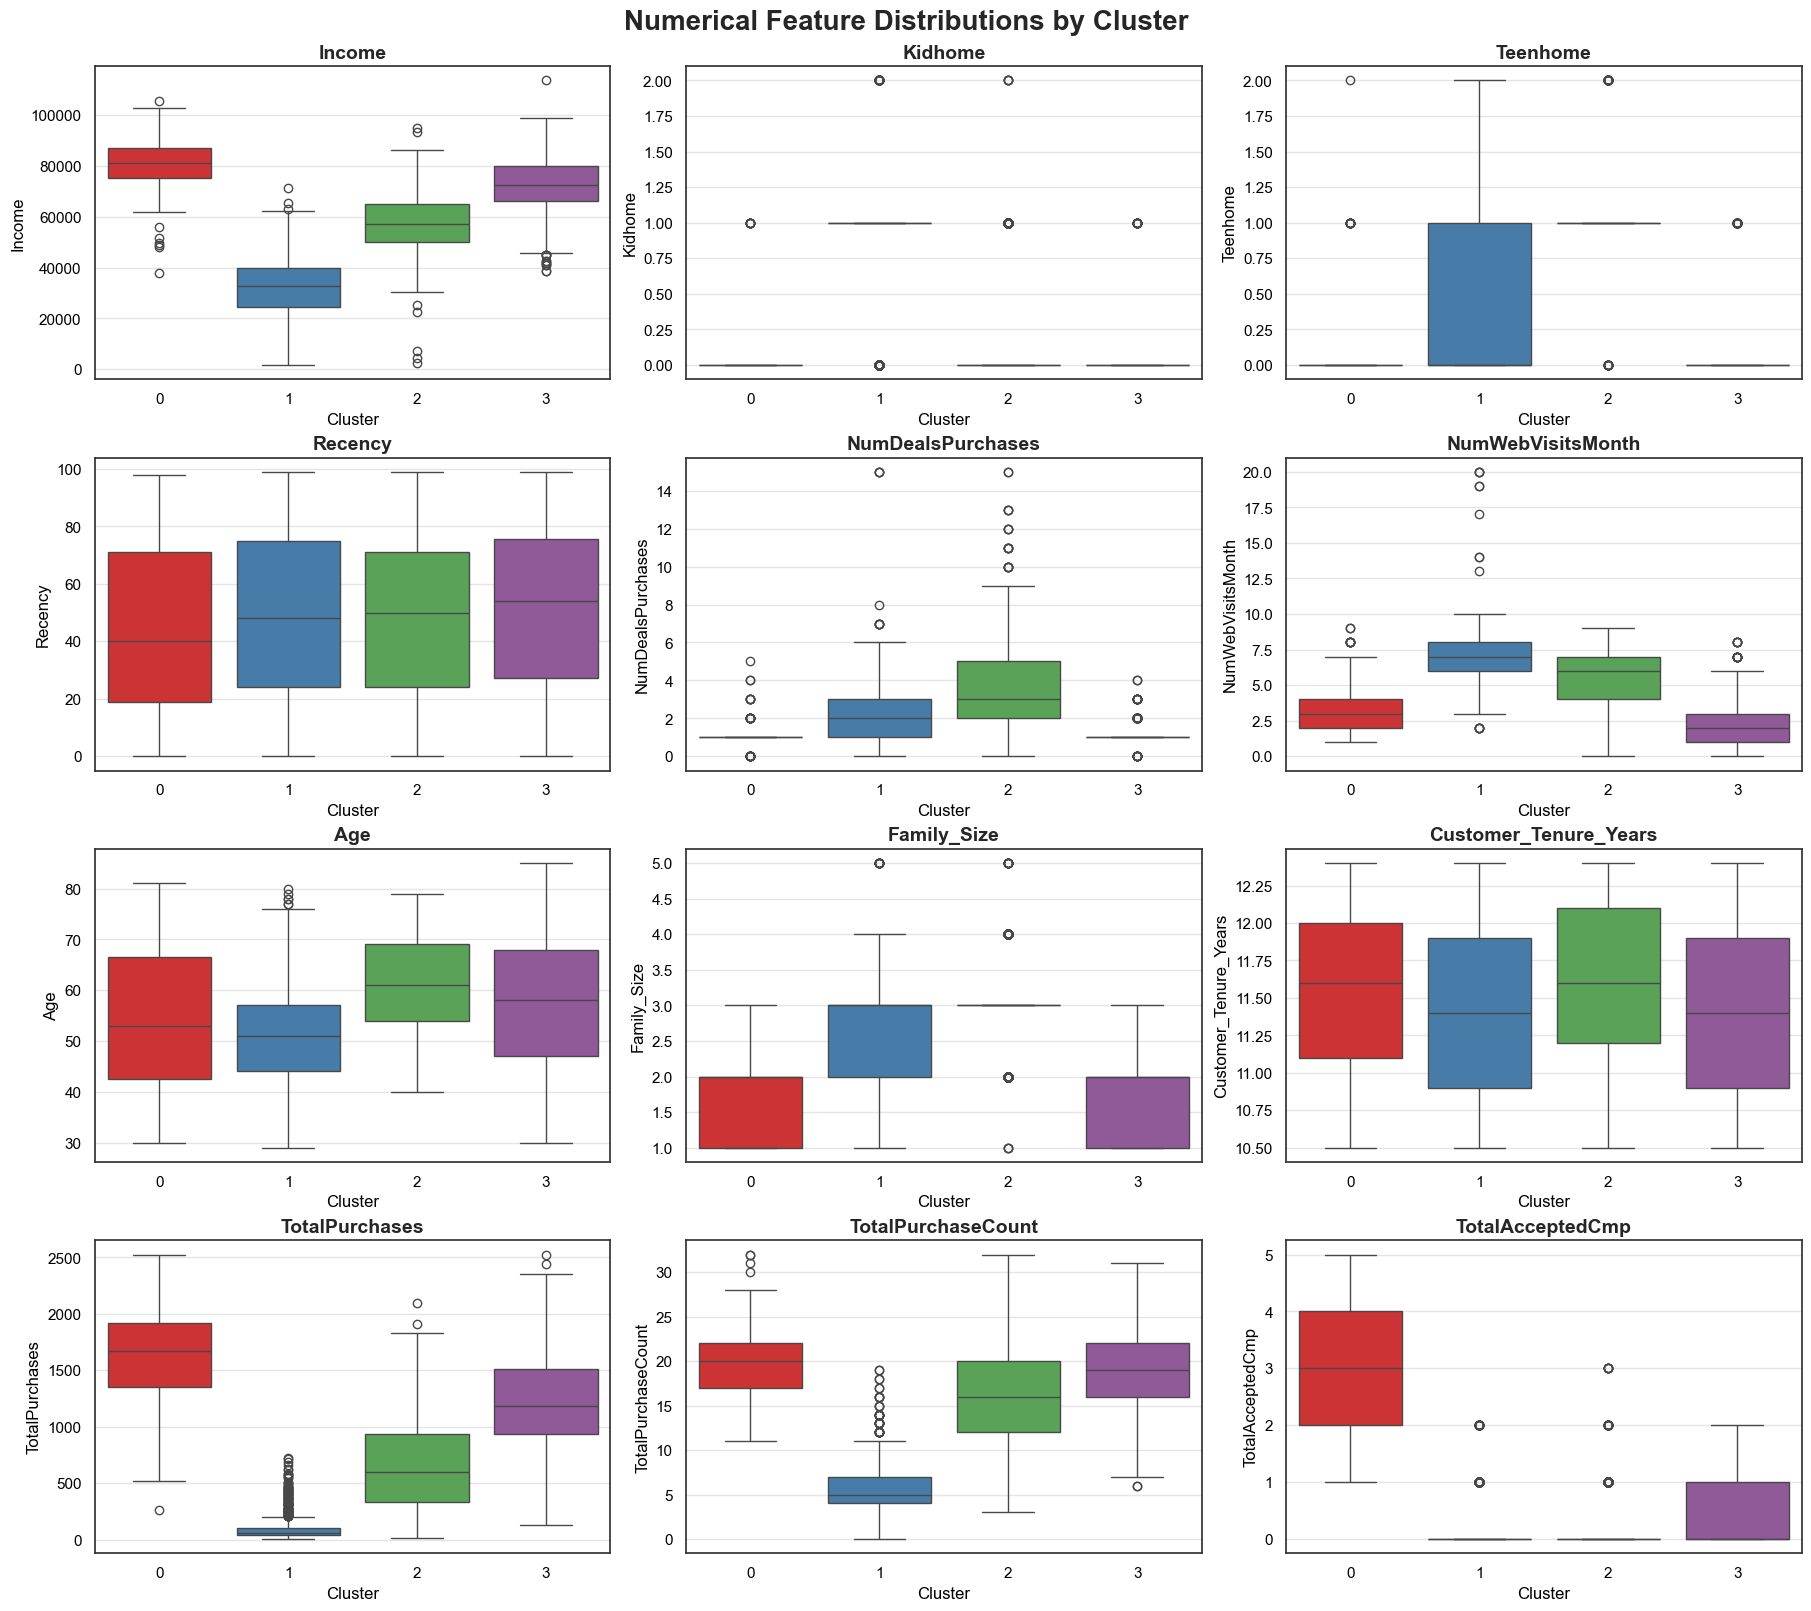

In [25]:
import math
#------------------Cluster Analysis for Numerical Variables -------------------------#
# -------------------- THEME --------------------
sns.set_theme(
    style="whitegrid",
    rc={
        'axes.facecolor': 'white',
        'figure.facecolor': 'white',
        'grid.color': '#e5e5e5',
        'axes.edgecolor': '#333333',
        'axes.labelcolor': 'black',
        'xtick.color': 'black',
        'ytick.color': 'black'
    }
)

# -------------------- NUMERICAL COLUMNS --------------------
numerical_cols = (
    df.select_dtypes(include=['int64', 'float64'])
      .columns
      .drop('Cluster', errors='ignore')
)

# -------------------- SUBPLOT LAYOUT --------------------
n_cols = 3                               # plots per row
n_rows = math.ceil(len(numerical_cols) / n_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(n_cols * 6, n_rows * 4),
    constrained_layout=True
)

axes = axes.flatten()

# -------------------- PLOTTING --------------------
for i, col in enumerate(numerical_cols):
    sns.boxplot(
        data=df,
        x='Cluster',
        y=col,
        palette='Set1', hue='Cluster',legend= False,
        ax=axes[i]
    )
    axes[i].set_title(col, fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(col)

# -------------------- REMOVE EMPTY SUBPLOTS --------------------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Numerical Feature Distributions by Cluster", fontsize=20, fontweight='bold')
plt.show()


Based on the above charts following are the main driving factors for cluster seperation 
- Income
- Family Size
- Marital Status
- Education
- Age
- Total Purchases
- Total Purchase Count 
- Number of Deal Purchases

In [26]:
from sklearn.preprocessing import StandardScaler

# Selected key features 
features = ["Income", "Family_Size", "TotalPurchases", "TotalPurchaseCount", "NumDealsPurchases", "Age"]

# Cluster means
cluster_means = df.groupby('Cluster')[features].mean()

# Standardize
scaler = StandardScaler()
cluster_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    columns=features,
    index=cluster_means.index
)

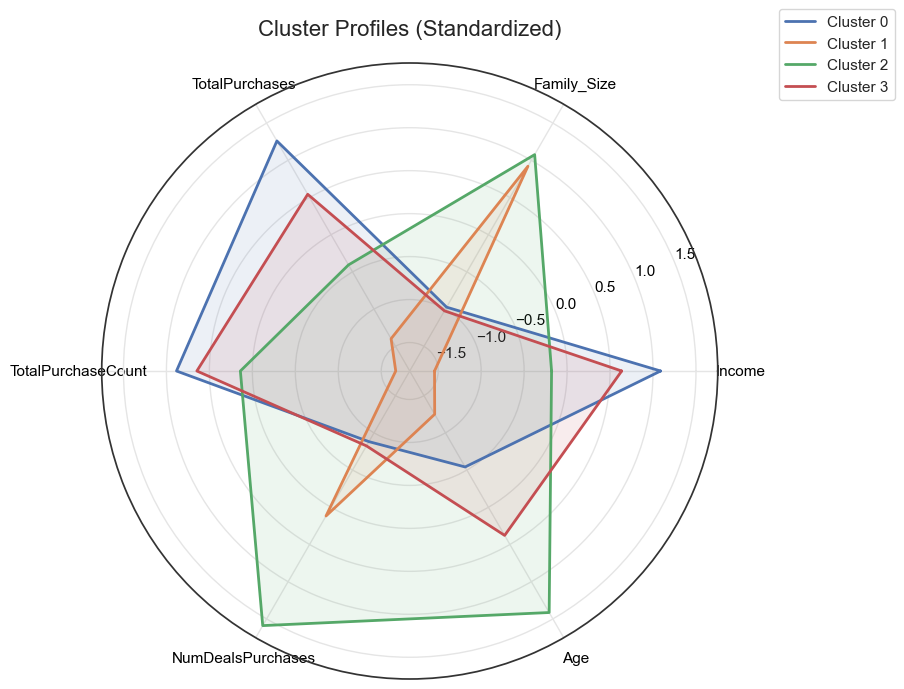

In [27]:
# Number of variables
num_vars = len(features)

# Angles for axes
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each cluster
for cluster in cluster_scaled.index:
    values = cluster_scaled.loc[cluster].tolist()
    values += values[:1]

    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

# Axis labels
ax.set_thetagrids(np.degrees(angles[:-1]), features)
ax.set_title("Cluster Profiles (Standardized)", fontsize=16, pad=20)

# Legend
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.show()


In [28]:
from scipy.stats import zscore
cluster_z = df.groupby('Cluster')[numerical_cols].mean().apply(zscore)
cluster_z

,Income,Kidhome,Teenhome,Recency,NumDealsPurchases,NumWebVisitsMonth,Age,Family_Size,Customer_Tenure_Years,TotalPurchases,TotalPurchaseCount,TotalAcceptedCmp
Cluster,,,,,,,,,,,,
0,1.088109,-0.725706,-0.774115,-1.489117,-0.881955,-0.764399,-0.541843,-0.973439,0.720797,1.260017,0.883023,1.729885
1,-1.542670,1.695530,-0.109476,0.195688,0.116662,1.307227,-1.250394,0.920432,-0.972062,-1.397359,-1.668418,-0.655188
2,-0.180687,-0.231685,1.666213,-0.026990,1.590063,0.611626,1.414224,1.076221,1.244556,-0.405835,0.139488,-0.556567
3,0.635248,-0.738139,-0.782621,1.320419,-0.824770,-1.154454,0.378013,-1.023215,-0.993291,0.543177,0.645906,-0.518130


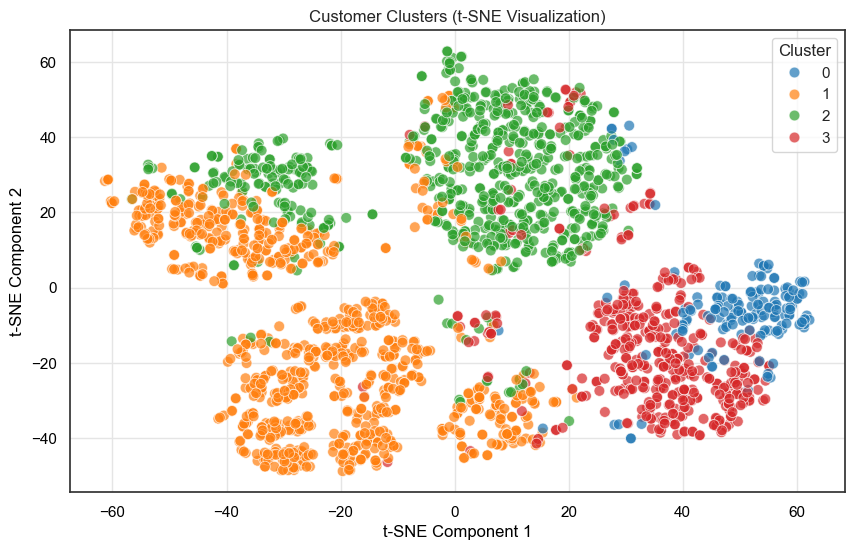

In [29]:
# Using t-SNE for Cluster visualization
tsne = TSNE(
    n_components=2,
    perplexity=30,
    max_iter=1000,
    random_state=42
)

X_tsne = tsne.fit_transform(X_transformed)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=df['Cluster'],
    palette='tab10',
    alpha=0.7,
    s=60
)

plt.title('Customer Clusters (t-SNE Visualization)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

Detailed cluster profile analysis can be found in the **Customer Profile Analysis** Markdown file within the project folder.
